# Primera parte: Caso ideal

Se cargan las librerias necesarias y se extra los datos de la imagen. Este presenta 1 espectro de ciencia sin ningún ruido particular.

In [1]:
#Tratamiento de filesystem
#import os
#import sys
#sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
##%load_ext autoreload
##%autoreload 2

import Recursos
#Tratamientos de datos
import numpy as np
#Gráficos
import matplotlib.pyplot as plt
import scipy.stats as stats
#Modelos
from sklearn.mixture import GaussianMixture
import seaborn as sns   #v0.11

In [3]:
#imagen ideal 
NOMBRE_IMG1 = 'A4762-HD166734.fits' 
#posee un espectro celeste
datos, clusters = Recursos.getInfo(NOMBRE_IMG1)
Y = np.sum(datos, axis=0) #sumariza los pixels en el eje x
x = np.arange(Y.size)

Se grafica junto a la imagen la función de interes a tratar.

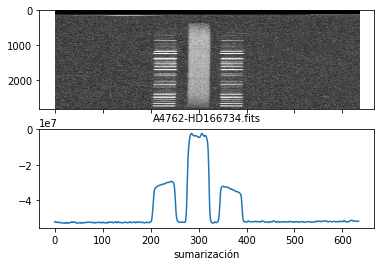

Dimensón de la funcion: (635,)


In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.imshow(datos, cmap='gray')
ax1.set_aspect('auto')
ax2.plot(x,Y)
ax1.set_xlabel(NOMBRE_IMG1)
ax2.set_xlabel("sumarización")
plt.show()
print('Dimensón de la funcion: '+str(Y.shape))


Configuración del modelo GMM a aplicar.

In [4]:
def modelo_gmm(datos, clusters):
    #Se configura el modelo
    gmm = GaussianMixture(
    n_components=clusters, 
    covariance_type='full')
    #n_init= nro_iters)

    #Se estima el modelo
    gmm.fit(datos)
   
    print("Datos del modelo:")
    print("centroides")
    print(gmm.means_)
    print("%")
    print(gmm.weights_)
    print("std")
    print(np.sqrt(gmm.covariances_))
    return gmm

Se aplica el modelo donde la cantidad de clusters es el valor obtenido de la metada de la imagen .fits multiplicada por 3. Esto se debe a que se considera no solo el espectro de ciencia sino tambien las lamparas de comparación. De forma que se pueda identificar los 3 centroides en la función de la imagen, los cuales se grafica juntos en la imagen de abajo.

Datos del modelo:
centroides
[[-52142368.58619651]
 [ -4023461.89340257]
 [-34174829.44564947]]
%
[0.75377639 0.06262036 0.18360326]
std
[[[ 326070.25887963]]

 [[1205704.47737026]]

 [[6898897.32758022]]]


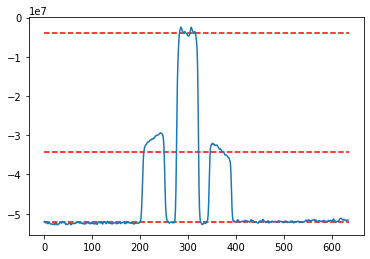

In [5]:
#se ajusta la dimensión de los datos con reshape - paso necesario
modelo = modelo_gmm(Y.reshape(-1,1), clusters*3)
#se grafica funcion
plt.plot(x,Y)
#se marcan lineas correspondientes a los centroides obtenidos
plt.hlines(modelo.means_,0, x.size,colors='r',linestyles='dashed')
plt.show()

Tal como se observa los resultados no se presentan adecuadamente en el eje, es decir sus valores están ubicados en el eje y. De modo que, se plantea una manipulación previa en los datos para una mejor presentación. 
Paso 1: Dado que los valores de la función presenta valores negativos se aplica la normalización Min-Max a los datos de la imagen para que la función obtenga valores positivos.

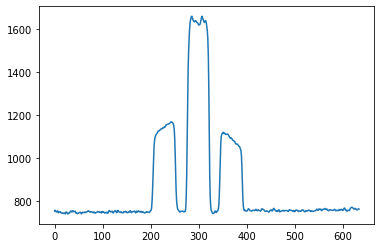

In [5]:
#normalizacion 2d
def normalize(vector):
    v = np.array(vector.copy(), dtype=np.float64)
    return(v - v.min()) / (v.max() - v.min())
    #pixels -= pixels.min()
    #pixels /= (pixels.max() - pixels.min())

pixeles = normalize(datos)
Y = np.sum(pixeles, axis=0) #sumariza los pixels en el eje x
plt.plot(Y)


Paso 2: Se generan nuevos datos de acuerdo al siguiente criterio; dada la función que contiene 635 elementos se considera al rango de valores en el eje x como el nuevo valor en el eje y. De modo que cada valor en el eje y de la función original indique la cantidad de datos a generar.
Aunque para realizar este paso, es necesario reducir la cantidad de datos a generar por eso se reduce a los valores de la función lo suficiente para ello con una constante acorde.

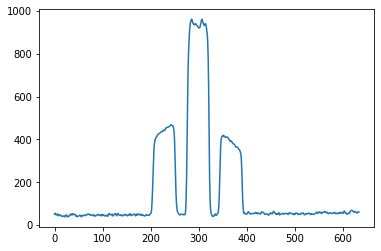

In [6]:
Y_nuevo = Y.copy()  #funcion original reducida
#se reduce valor en y para no generar una enorme cantidad de valores en pasos posteriores
Y_nuevo -= 700  
plt.plot(Y_nuevo)

In [7]:
#se crean los nuevos datos
nuevo_dataset = []   #nueva funcion
for i in range(Y_nuevo.size):
    #Y[i] es un valor decimal entonces se aplica int
    #se genera tantos datos como diga Y[i]  con el valor i
    nuevos = np.ones( int(Y_nuevo[i])) *i   
    nuevo_dataset = np.append(nuevo_dataset, nuevos)
    
#se muestra la nueva dimension de los datos generados
print('Dimension de los nuevos datos: '+str(nuevo_dataset.shape))

Dimension de los nuevos datos: (105825,)


Se grafica los nuevos datos vs el original reducido para comparar visualmente. Tambien cómo se distribuye los valores del nuevo_dataset.

In [9]:
#para realizar un cambio del tamaño de figuras -pyplot- en el entorno
plt.rcParams["figure.figsize"] = [10, 5] 

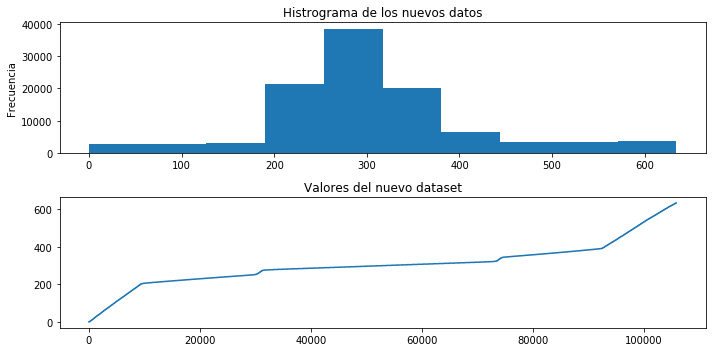

In [26]:
fig,(ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
ax1.hist(nuevo_dataset)
ax1.set_ylabel('Frecuencia')
ax1.set_title('Histrograma de los nuevos datos')
ax2.plot(nuevo_dataset)
ax2.set_title('Valores del nuevo dataset')
fig.tight_layout()  #para evitar que solape titulos con graficos
plt.show()

Tal como se ve en el histograma hay mayor frecuencia en el centro de la función, donde justamente se encuentran los 3 centroides que se busca detectar.

La estimación de densidad del kernel (KDE) presenta una solución diferente al mismo problema. En lugar de utilizar contenedores discretos, una gráfica KDE suaviza las observaciones con un núcleo gaussiano, produciendo una estimación de densidad continua. Por lo que se grafica primero ambos enfoques, tanto el histograma como KDE. Luego se muestra este último por separado.

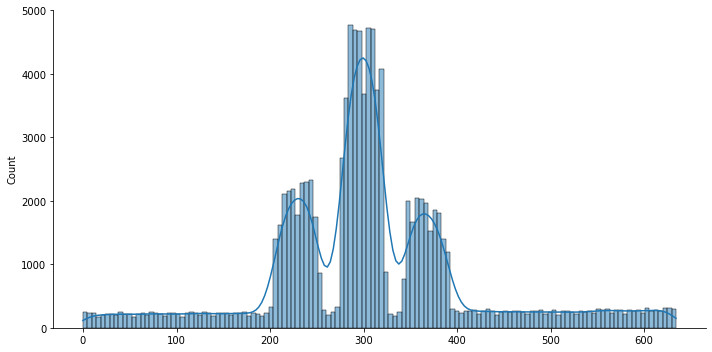

In [24]:

sns.displot(data=nuevo_dataset, kde=True, color='#1f77b4', height=5, aspect=2)   #aspect=ancho

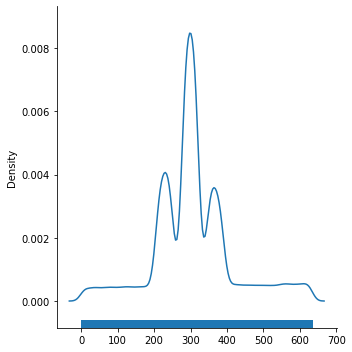

In [26]:
 sns.displot(data=nuevo_dataset, kind="kde", color='#1f77b4',  rug=True)

Se aplica los nuevos datos generados al modelo GMM.

In [27]:
modelo_nuevo = modelo_gmm(nuevo_dataset.reshape(-1,1), clusters*3)

Datos del modelo:
centroides
[[296.7623741 ]
 [532.76880197]
 [ 86.38886673]]
%
[0.82345036 0.10522373 0.07132591]
std
[[[55.8405285 ]]

 [[64.5548245 ]]

 [[55.02589954]]]


Una vez obtenido resultados cuyos valores si se representen en el eje correcto, se grafica la distibución normal correspondiente a cada resultado. 

In [68]:
#se obtienen los resultados del modelo
mu = np.abs(modelo_nuevo.means_.flatten())
std = np.sqrt(np.abs(modelo_nuevo.covariances_.flatten()))
num_componentes = 3  #clusters

#grafico de los resultados
extend_window = 50 #para extender el rango en el eje x
#para trazar un grafico suave se define step=0.1
x_values = np.arange(nuevo_dataset.min()-extend_window, nuevo_dataset.max()+extend_window, 0.1) 

AttributeError: 'FacetGrid' object has no attribute 'get_lines'

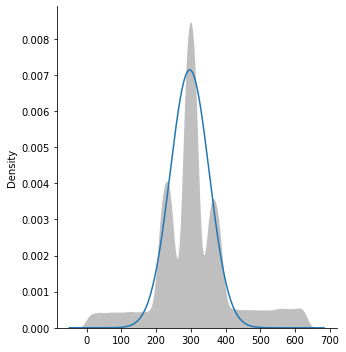

In [67]:
#plt.plot(nuevo_dataset, np.zeros(nuevo_dataset.shape), linestyle='None', markersize = 10.0, marker='o') 
#se grafica las 3 distribuciones normales
ax = sns.displot(data=nuevo_dataset, kind="kde", color='black', palette="crest", fill=True, linewidth=0,)
for i in range(num_componentes):
    y_values = stats.norm(mu[i], std[i])
    plt.plot(x_values, y_values.pdf(x_values))
    #plt.fill_between( mu[i]-std[i], mu[i]+std[i])
    #plt.fill( y_values.pdf(x_values), mu[i]-std[i],facecolor='blue', alpha=0.5)
    #plt.fill_between(x_values, mu[i]-std[i], mu[i]+std[i], where= y_values > 0, color='green', alpha=0.5)
    x0 = mu[i]-std[i]
    x1 = mu[i]+std[i]
    kde_x, kde_y = ax.get_lines()[0].get_data() #ax.lines[0].get_data()
    ax.fill_between(kde_x, kde_y, where=(kde_x<x0) | (kde_x>x1) , 
                interpolate=True, color='#EF9A9A')
    plt.axvline(x= mu[i]+std[i], ymin=0, linestyle = "dashed", color = "red", linewidth = 0.9)
    plt.axvline(x= mu[i]-std[i], ymin=0, linestyle = "dashed", color = "red", linewidth = 0.9)
    plt.show()

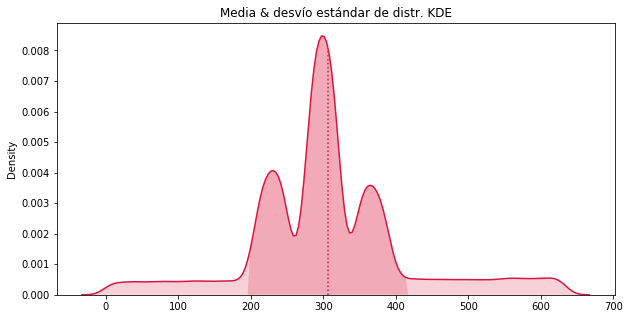

In [72]:
#prueba 2
ax = sns.kdeplot(nuevo_dataset, shade=False, color='crimson')
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
middle = nuevo_dataset.mean()
sdev = nuevo_dataset.std()
left = middle - sdev
right = middle + sdev
plt.title('Media & desvío estándar de distr. KDE')
plt.vlines(middle, 0, np.interp(middle, xs, ys), color='crimson', ls=':')
plt.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
plt.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
plt.show()

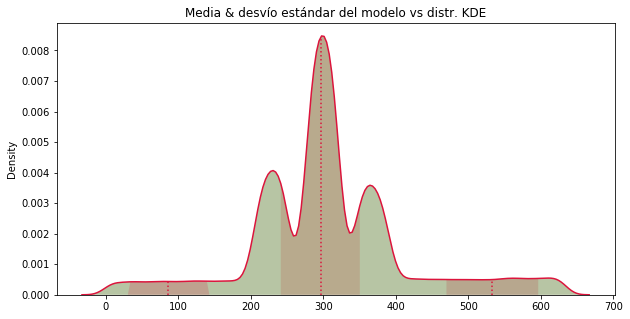

In [80]:
ax = sns.kdeplot(nuevo_dataset, shade=False, color='crimson')

#ax = sns.displot(data=nuevo_dataset, kind="kde", color='black', palette="crest", fill=True, linewidth=0)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

for i in range(num_componentes):
    y_values = stats.norm(mu[i], std[i])
    #plt.plot(x_values, y_values.pdf(x_values))
    x0 = mu[i]-std[i]
    x1 = mu[i]+std[i]
    
    plt.title('Media & desvío estándar del modelo vs distr. KDE')
    plt.vlines(mu[i], 0, np.interp(mu[i], xs, ys), color='crimson', ls=':')
    plt.fill_between(xs, 0, ys, alpha=0.2)
    plt.fill_between(xs, 0, ys, where=(x0 <= xs) & (xs <= x1), interpolate=True, facecolor='crimson', alpha=0.2)
plt.show()

In [122]:
from mpl_toolkits.axes_grid1 import host_subplot

def graficar_regiones(modelo, clusters):
    mu = np.abs(modelo.means_.flatten())
    std = np.sqrt(np.abs(modelo.covariances_.flatten()))
    ax = sns.kdeplot(nuevo_dataset, shade=False, color='crimson')
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    
    #fig,ax1 = plt.subplots()
    for i in range(clusters):
        y_values = stats.norm(mu[i], std[i])
        x0 = mu[i]-std[i]
        x1 = mu[i]+std[i]
        
        ax.set_ylabel("Densidad de nuevos datos",color="crimson",fontsize=14)
        ax.set_title('Media & desvío estándar del modelo vs distr. KDE')
        #ax.legend()
        ax.vlines(mu[i], 0, np.interp(mu[i], xs, ys), color='crimson', ls=':')
        ax.fill_between(xs, 0, ys, alpha=0.2)
        ax.fill_between(xs, 0, ys, where=(x0 <= xs) & (xs <= x1), interpolate=True, facecolor='crimson', alpha=0.2)
    
    #se grafica con otro eje y para la funcion reducida de los datos 
    ax2=ax.twinx()
    ax2.plot(Y_nuevo, color="blue",ls='-')
    ax2.set_ylabel("Y(valores de los datos)",color="blue",fontsize=14)
    #plt.legend(['KDE','Función de los datos'])
    plt.show()
    

En este punto, es posible solapar tanto la función de los datos con las distrubuciones resultantes  en un mismo grafico para observar su correspondecia.  

In [120]:
modelo_nuevo = modelo_gmm(nuevo_dataset.reshape(-1,1), 5)


Datos del modelo:
centroides
[[299.04005782]
 [517.83619176]
 [102.08098777]
 [228.92802952]
 [367.23249296]]
%
[0.4062661  0.12192773 0.08743994 0.20328618 0.18108006]
std
[[[13.92007053]]

 [[71.69210705]]

 [[61.08257825]]

 [[15.54724524]]

 [[16.44820314]]]


# 2da parte

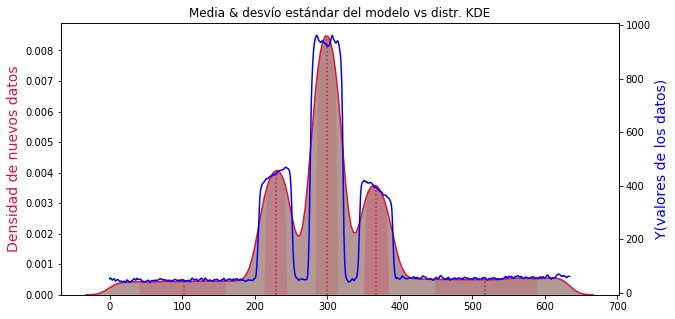

In [123]:
graficar_regiones(modelo_nuevo, 5)
#fig=plt.figure()
#ax1 = plt.subplot(211, fig= graficar_regiones(modelo_nuevo, 5))
#ax2 = plt.subplot(212, sharex = ax1)
#ax2.plot(Y_nuevo)